In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')


                              name  \
0     2024 Jeep Wagoneer Series II   
1  2024 Jeep Grand Cherokee Laredo   
2         2024 GMC Yukon XL Denali   
3       2023 Dodge Durango Pursuit   
4            2024 RAM 3500 Laramie   

                                         description   make           model  \
0  \n      \n        Heated Leather Seats, Nav Sy...   Jeep        Wagoneer   
1  Al West is committed to offering every custome...   Jeep  Grand Cherokee   
2                                                NaN    GMC        Yukon XL   
3  White Knuckle Clearcoat 2023 Dodge Durango Pur...  Dodge         Durango   
4  \n      \n        2024 Ram 3500 Laramie Billet...    RAM            3500   

   year    price                                             engine  \
0  2024  74600.0                            24V GDI DOHC Twin Turbo   
1  2024  50170.0                                                OHV   
2  2024  96410.0  6.2L V-8 gasoline direct injection, variable v...   
3  2023  468

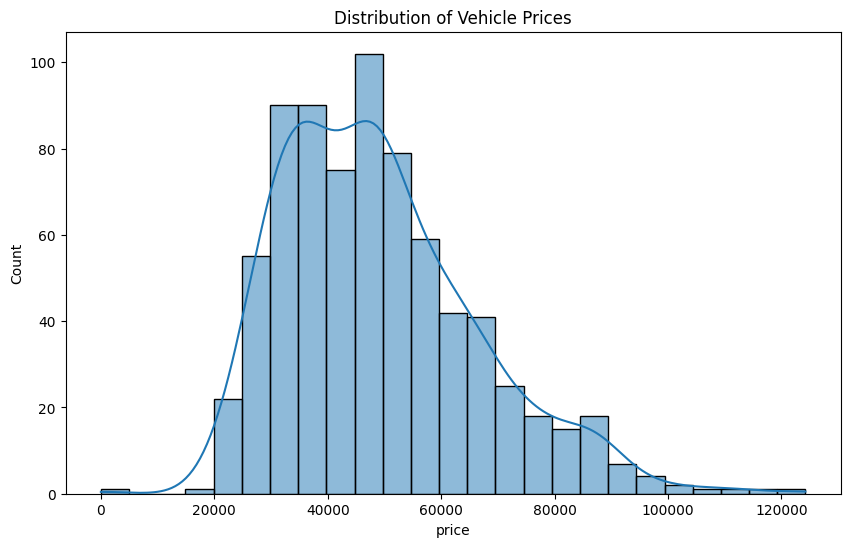

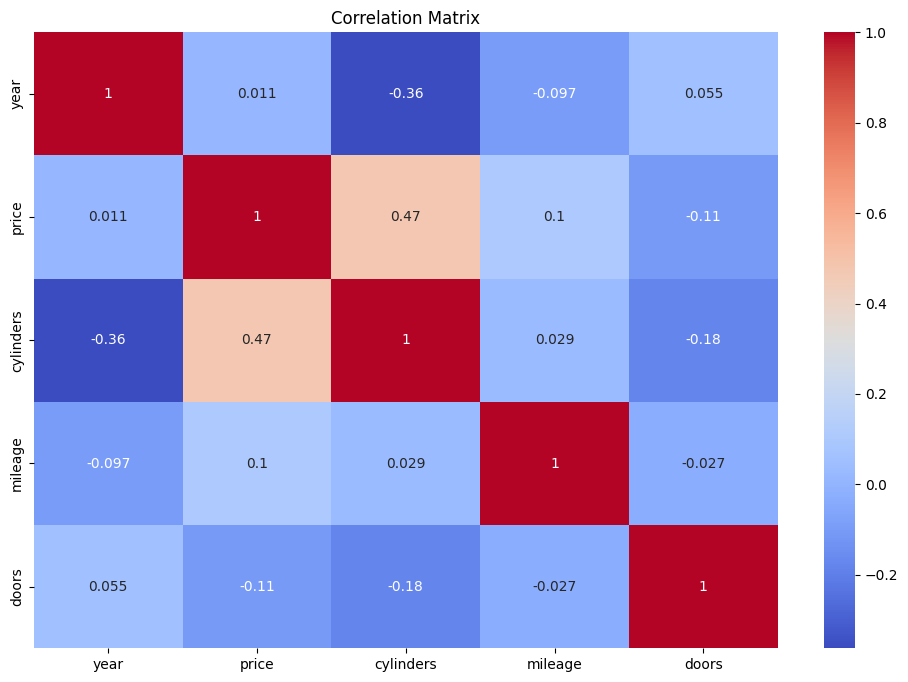

In [7]:

# Load the dataset
# Assuming the data is in a CSV file named 'vehicles.csv'
df = pd.read_csv('dataset.csv')

# Initial data exploration
print(df.head())
print(df.info())
print(df.describe())
df = df.dropna()
# Visualize the distribution of the target variable (price)
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True)
plt.title('Distribution of Vehicle Prices')
plt.show()

# Visualize correlations
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Feature engineering
# Extract useful information from the 'name' column if needed
# Example: df['name_length'] = df['name'].apply(len)

# Preprocessing
# Separate features and target
X = df.drop('price', axis=1)
y = df['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing for numeric and categorical columns
numeric_features = ['year', 'mileage', 'cylinders', 'doors']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['make', 'model', 'fuel', 'transmission', 'body', 'drivetrain']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Model pipeline
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Linear Regression': LinearRegression()
}


Random Forest Results:
MSE: 58229544.98
RMSE: 7630.83
R2 Score: 0.83

Gradient Boosting Results:
MSE: 73401579.79
RMSE: 8567.47
R2 Score: 0.79

Linear Regression Results:
MSE: 65732853.22
RMSE: 8107.58
R2 Score: 0.81

Best parameters: {'regressor__max_depth': None, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Best score: 7868.696707014254


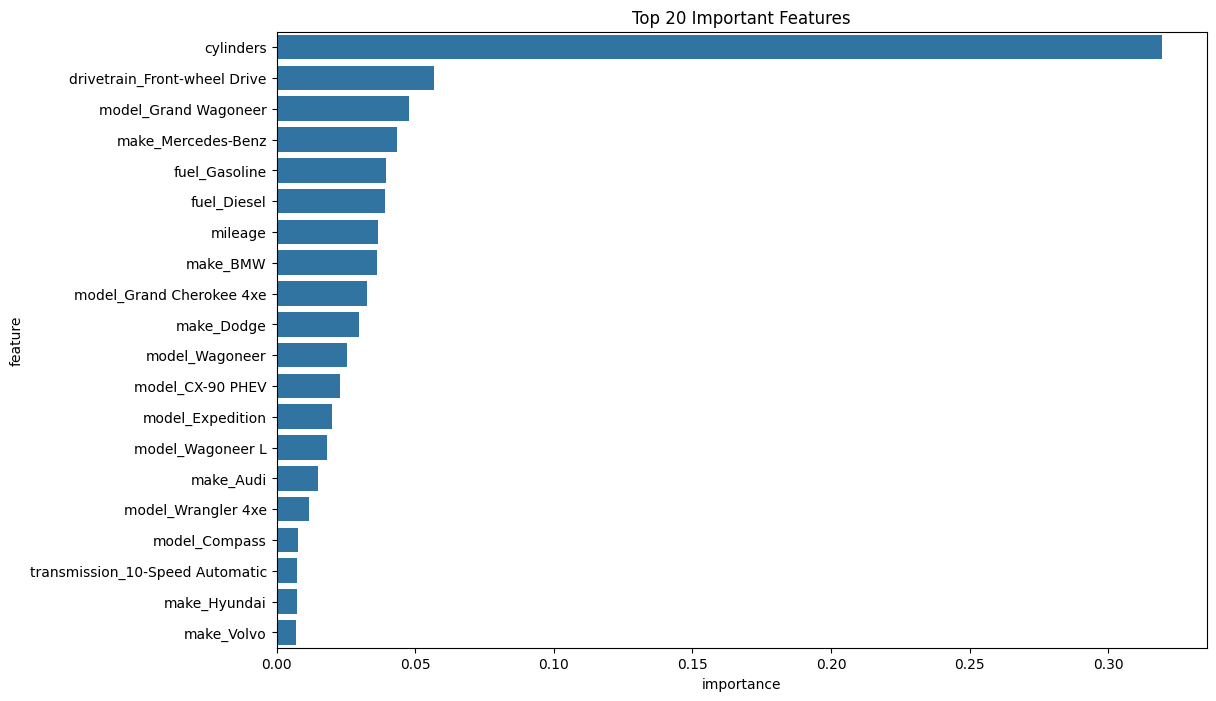

In [8]:

results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MSE': mse,
        'RMSE': np.sqrt(mse),
        'R2': r2
    }
    
    print(f"{name} Results:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {np.sqrt(mse):.2f}")
    print(f"R2 Score: {r2:.2f}\n")

# Hyperparameter tuning for the best model
# Example with Random Forest
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", np.sqrt(-grid_search.best_score_))

# Feature importance for the best model
best_model = grid_search.best_estimator_
rf_model = best_model.named_steps['regressor']

# Get feature names after one-hot encoding
preprocessor = best_model.named_steps['preprocessor']
feature_names = numeric_features + \
                list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

importances = rf_model.feature_importances_
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
plt.title('Top 20 Important Features')
plt.show()

In [9]:
import joblib

# After finding your best model (from your previous code)
best_model = grid_search.best_estimator_

# Save the model to disk
joblib.dump(best_model, 'vehicle_price_predictor.joblib')

['vehicle_price_predictor.joblib']